A runtime comparison with FairLearn reductions on multi-group adult data.

There is relatively little to see here, as both FairLearn and OxonFair naturally support multiple groups. 

We load the dataset and iteratively merge small groups into the group `Other'. Then we record time-taken, accuracy, and demographic disparity.

In [1]:
from oxonfair import FairPredictor, dataset_loader
from oxonfair import group_metrics as gm
from oxonfair.utils.performance import evaluate_fairness
import fairlearn.reductions

import xgboost
import pandas as pd
import numpy as np
import fairlearn
import time
import pandas as pd
train_data, val_data, test_data = dataset_loader.adult('race',train_proportion=0.7,test_proportion=0.3,seperate_groups=True,seed=0)

start=time.perf_counter()
predictor = xgboost.XGBClassifier().fit(X=train_data['data'], y=train_data['target'])
stop=time.perf_counter()
print('Training time of xgboost without fairness')
print(stop-start)



Training time of xgboost without fairness
0.6205382919999991


Text(0.5, 1.0, 'Prevalence of ethinicities in the adult dataset')

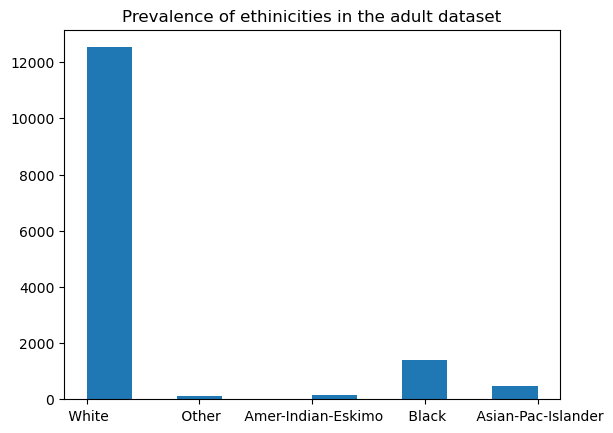

In [2]:
from matplotlib import pyplot as plt
plt.hist(test_data['groups'])
plt.title('Prevalence of ethinicities in the adult dataset')

In [3]:
#Create arrays to hold scores
anon=np.zeros((3,4))
fairl=np.zeros((3,4))

In [4]:
for i, name in enumerate ((' Amer-Indian-Eskimo', ' Asian-Pac-Islander', ' Black', ' Other')):
    # This looks like a bug, why are we merging ' Other' with itself.
    # But we need a final null op to evaluate fairness when the groups are  White vs all others.
    start=time.perf_counter()
    fpred = FairPredictor(predictor,train_data)
    fpred.fit(gm.accuracy,gm.demographic_parity,0.02)
    stop=time.perf_counter()
    score=fpred.evaluate_fairness(test_data,metrics={'a':gm.accuracy,'b':gm.demographic_parity},verbose=False)
    anon[0,i]=score['updated']['a']#['updated']
    anon[1,i]=score['updated']['b']#['updated']
    anon[2,i]=stop-start
    start=time.perf_counter()
    fair = fairlearn.reductions.ExponentiatedGradient(xgboost.XGBClassifier(),fairlearn.reductions.DemographicParity())
    fair.fit(X=train_data['data'],
         y=train_data['target'],
         sensitive_features=train_data['groups'])
    stop=time.perf_counter()
    score=evaluate_fairness(test_data['target'], fair.predict(test_data['data']), test_data['groups'], metrics={'a':gm.accuracy,'b':gm.demographic_parity},verbose=False)
    fairl[0,i]=score['a']#['updated']
    fairl[1,i]=score['b']#['updated']
    fairl[2,i]=stop-start
    train_data['groups'][train_data['groups']==name]=' Other'
    test_data['groups'][test_data['groups']==name]=' Other'

In [5]:
anon_df=pd.DataFrame(anon.T,columns=['Accuracy','Demographic Parity','Time'])
fairl_df=pd.DataFrame(fairl.T,columns=['Accuracy','Demographic Parity','Time'])
anon_df['Name']='OxonFair'
fairl_df['Name']='FairLearn'
anon_df=anon_df[['Name','Accuracy','Demographic Parity','Time']]
fairl_df=fairl_df[['Name','Accuracy','Demographic Parity','Time']]

In [6]:
results = pd.concat((anon_df,fairl_df), axis=0).sort_index()

In [7]:
results

,Name,Accuracy,Demographic Parity,Time
0,OxonFair,0.868619,0.019085,41.136526
0,FairLearn,0.865001,0.037732,46.391113
1,OxonFair,0.867663,0.012305,0.804408
1,FairLearn,0.866639,0.016227,27.712763
2,OxonFair,0.867936,0.021317,0.071277
2,FairLearn,0.865070,0.007104,25.013719
3,OxonFair,0.868823,0.003093,0.049922
3,FairLearn,0.869165,0.002346,20.080540
